#Titantic背景说明
·集体票 ：可多人购买合资一张票
·船长下令优先让妇孺和儿童登上救生艇：船员开始劝导头等舱乘客（妇孺儿童）登上救生艇，在船的左舷，救生船只载妇女和儿童。在右舷，则是妇女优先逃生之后允许男性登艇。
·出发的当天晚7点，泰坦尼克号抵达法国瑟堡港。另一批乘客和货物搭乘“游牧”号和“交通”号两艘专用摆渡船登上了泰坦尼克号

#导入包和数据

In [1]:
#导入相关的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 设置图形的风格
sns.set_style("darkgrid")
sns.set_palette("Set2")

# 显示DataFrame的所有内容
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
#导入数据
df_train = pd.read_csv("D:\\dataanalyse\\compete\\kaggle\\Titanic\\titanic\\train.csv")
df_test = pd.read_csv("D:\\dataanalyse\\compete\\kaggle\\Titanic\\titanic\\test.csv")
df = pd.concat([df_train,df_test]).reset_index().drop(['index'],axis = 1)
n_train = df_train.shape[0]
n_all = df.shape[0]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#EDA探索分析
##字段和特征信息
    PassengerId：乘客ID，对 预测 应该没啥用
    Survived: 因变量, 训练集里面都是0或者1, 表示是否生存, 测试集里面都是NaN
###特征
    Pclass:  表示阶层, 越小表示阶层越高, 从生存率高低或者Fare的平均值高低可以看出这一点.
    Sex: 性别, "女士孩子优先"原则让性别对生存率影响较大.
    Age: 年龄, "女士孩子优先"原则应该会让未成年人的生存率提高, 其他各个年龄段的生存率是否不同呢?
    Fare: 船票的总价(一张船票有可能让好几个乘客上船)
    Embarked: 上船地点.
###潜在特征
    Name: 姓名好像无法决定生死
    Ticket: 船票号码
    Cabin: 船舱号码
    SibSp: 兄弟姐妹或者配偶的个数
    Parch: 父母或者孩子的个数

##1.1可视化理解数据和特征

In [3]:
#关于因变量
Survived_avg = np.around(df.Survived.mean(),decimals = 2)
print(f'平均生存率;{Survived_avg}')

平均生存率;0.38


In [4]:
#为了绘图的方便，自己定义一个函数用来绘图
def plot_category(df,feature,group = None):
    """
    为了方便对所有特征进行比较, 建议对连续型特征进行离散化后, 也用这个绘图函数.
    对1个或者2个类别特征进行绘图
    返回两张子图:
    第一张是各个level的样本个数
    第二张是各个level下的生存率, 以及95%置信区间
    """
    fig,(ax0,ax1) = plt.subplots(nrows =1 ,ncols = 2,figsize=(10,5),dpi = 100)
    sns.countplot(x = feature , hue = group ,data = df, ax=ax0)
    sns.barplot(x = feature , y = "Survived" ,hue = group ,data = df,ax=ax1)
    ax1.hlines(Survived_avg,-0.5,df[feature].nunique()- 0.5 ,
              colors = "red", linestyles = 'dashed',
              )
    if not group:
        plt.suptitle(feature)
    else:
        plt.suptitle(feature + '|' +group)

###新特征
·"女士和孩子优先"原则下, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可
·"女士和孩子优先"原则下, 男孩有必要从男性中分离出来, 男孩称为"boy", 成年男性称为"man"
·为了和原先的特征"Sex"作区分, 称为"Title", 这两个特征的信息量是有比较大的重叠的, 可以考虑保留其中一个. 

In [5]:
df["Title"] = "man"     #表示增加了一列，值为 man
df.loc[df['Sex'] == 'female','Title'] = 'woman'   #利用布尔索引
df.loc[df['Name'].str.contains('Master'),'Title'] = 'boy'
df['Title'].value_counts(normalize = True)

man      0.597403
woman    0.355997
boy      0.046600
Name: Title, dtype: float64

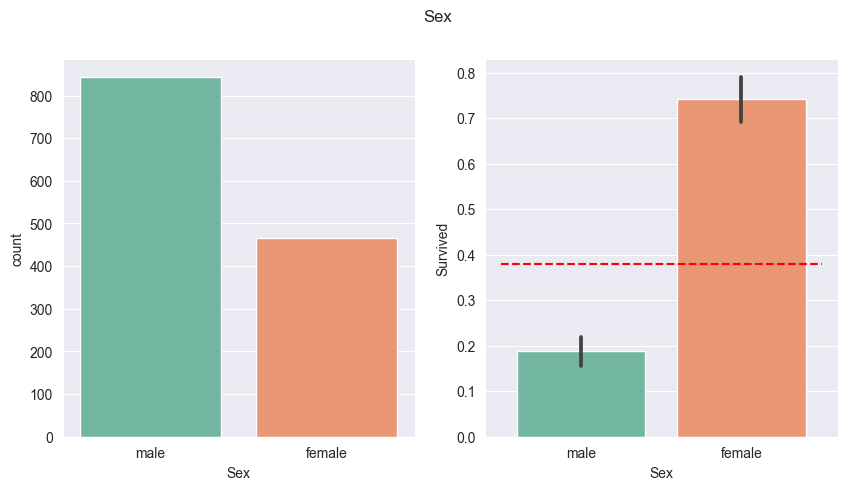

In [6]:
plot_category(df,"Sex")

Sex图例说明
·左图：统计了男性和女性的数量
·右图：表明了 男性 和女性的 生存率平均值的点估计 和 误差（置信区间）
·女性生存率显著高于男性

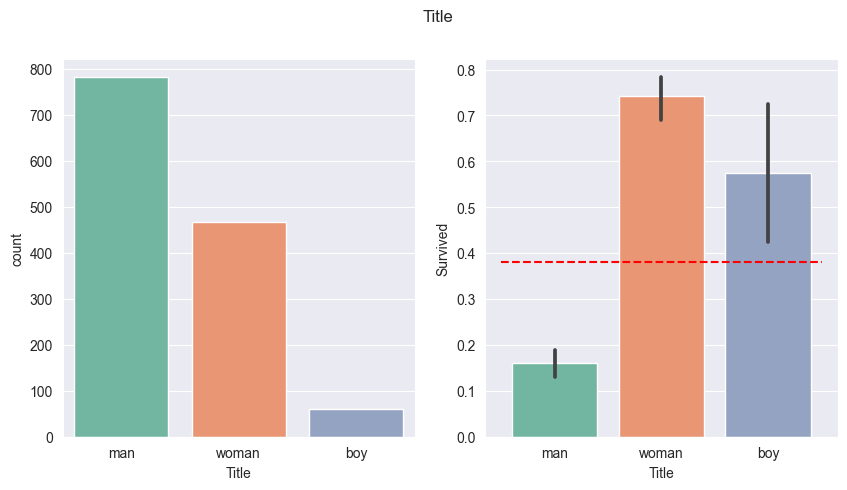

In [7]:
plot_category(df,'Title')

TItle图说明
·发现boy虽然也是男性, 但是生存率与man截然不同, man生存率不到20%, 而boy生存率接近60%
·说明对男性分成细分成两类, 是有价值的
·有遗憾的地方在于: boy的占比太小了, 对整体成绩的提升非常有限(理论上, 准确率最多提高4.7%左右)

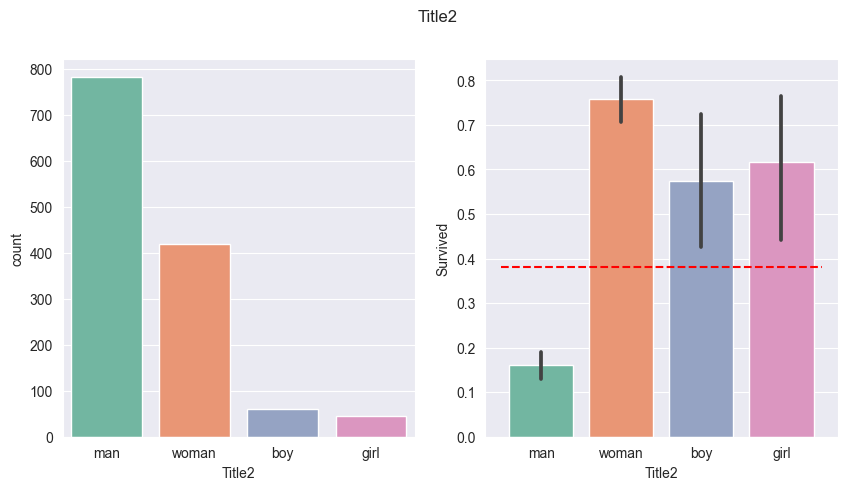

In [8]:
#查看女孩  定义小于14岁为女孩
df['Title2'] = df['Title']
df.loc[(df.Title == 'woman')&(df.Age < 14),'Title2'] = 'girl'
plot_category(df,'Title2')

·发现woman与girl的生存率并没有显著差别, 因此, 不需要特别分离出女孩了, 女孩和成年女性分为一类即可

####新特征
    Fare: 船票的总价(一张船票有可能让好几个乘客上船)
    因此, Fare是一个交叉性特征, 同时考虑了平均价格和一张票的乘客数量
    对Fare这个特征进行"提纯", 求平均价格(Pfare), 平均价格更能体现出乘客的地位, 从而反映在生存率上.
    有一些Fare取值为0, 这个设定不能接受, "没有免费的午餐", 将0赋值为NaN.

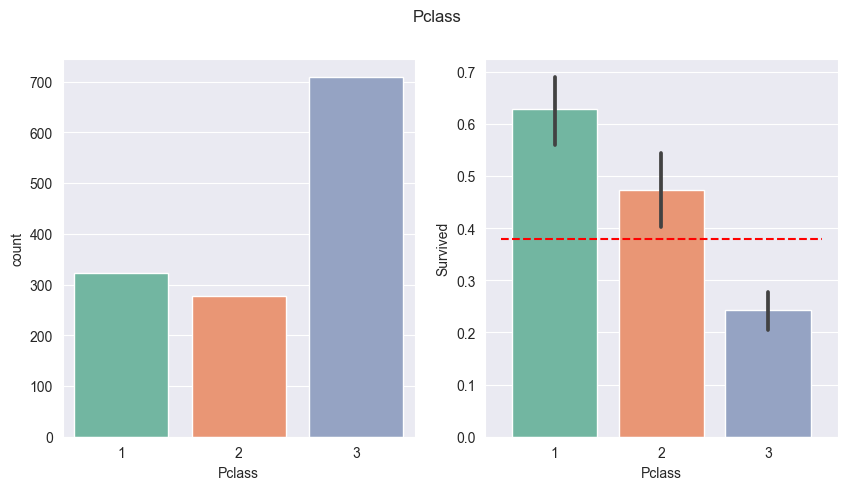

In [9]:
#Pclass
plot_category(df,'Pclass')

·等级越高，生存越高

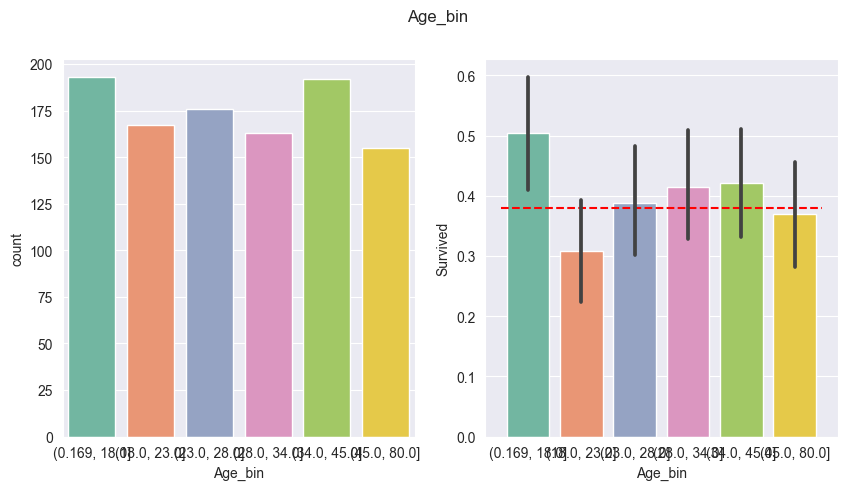

In [10]:
df['Age_bin'] = pd.qcut(df['Age'],6)
plot_category(df,"Age_bin")

·除了第一个区间(低年龄段), 其他区间的生存率都在平均生存率附近
·但是低年龄段已经通过Title体现过了
·因此, Age很可能是信息量低的特征, 可以考虑舍掉.

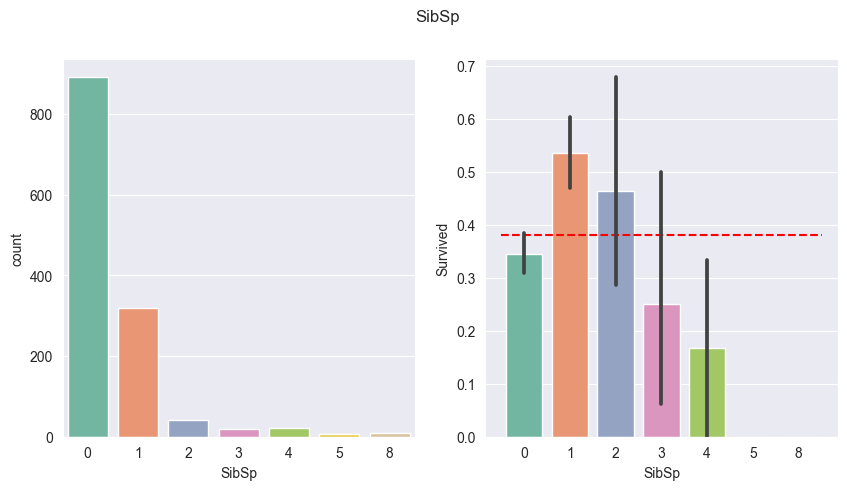

In [11]:
#SibSp
plot_category(df, "SibSp")

·当为0时, 稍微低于平均值
·当为1时, 稍微高于平均值
·当为2时, 平均值附近
·其他的取值因为样本少, 不做评价.
·总体来看, 有弱预测性.

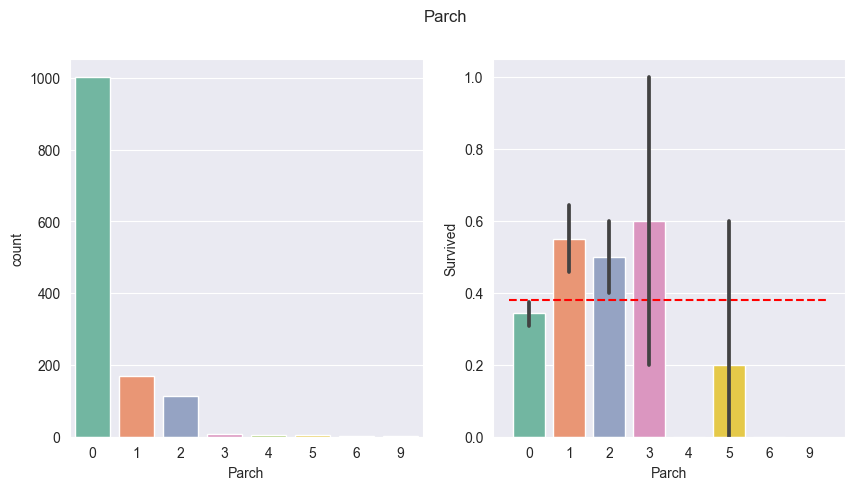

In [12]:
#Parch
plot_category(df, "Parch")

·当为0时, 稍微低于平均值
·当为1时, 稍微高于平均值
·当为2时, 稍微高于平均值
·其他的取值因为样本少, 不做评价.
·总体来看, 有弱预测性.

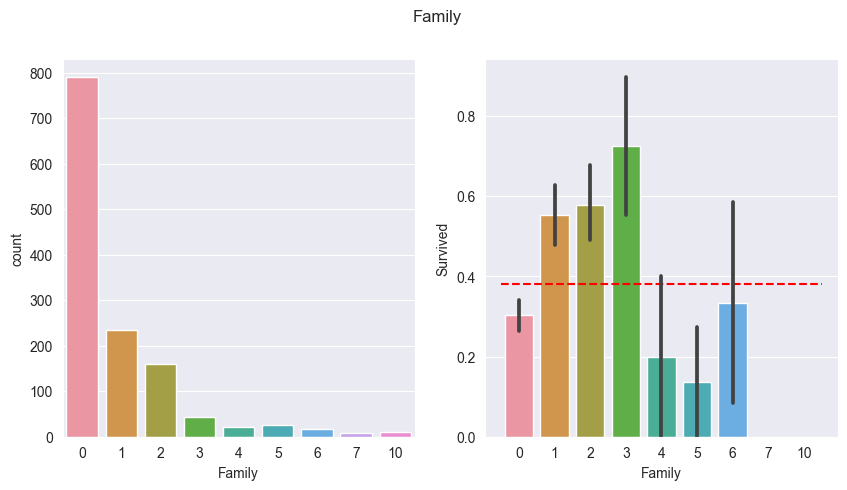

In [13]:
#Family
df['Family'] = df['SibSp']+df["Parch"]
plot_category(df,"Family")

·当为0时, 稍微低于平均值
·当为1或2或3时, 稍微高于平均值
·其他的取值因为样本少, 不做评价.
·总体来看, 有弱预测性, 但是比SibSp, Parch都要强.

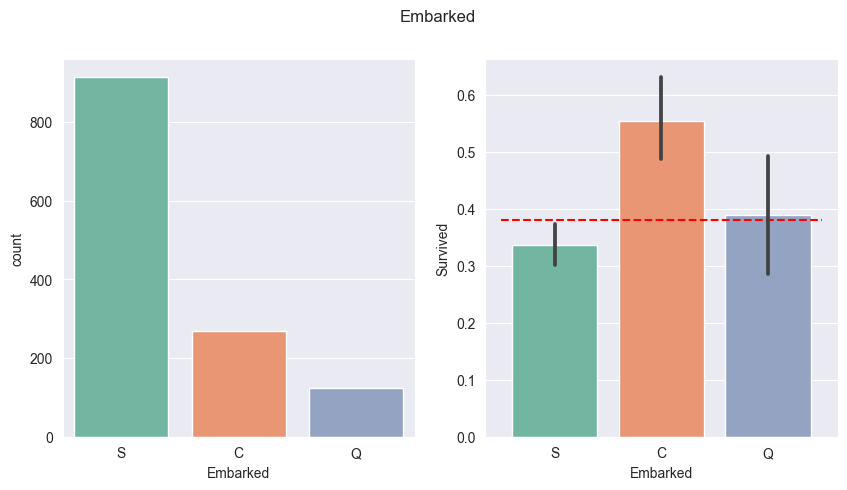

In [14]:
#Emarked
plot_category(df, "Embarked")

·取值为C时, 高于平均值
·取值为S时, 低于平均值
·取值为Q时, 在平均值附近
·总体来看, 是中等预测能力的特征.

##新特征: Pfare
·Fare: 船票的总价(一张船票有可能让好几个乘客上船：集体票)
·因此, Fare是一个交叉性特征, 同时考虑了平均价格和一张票的乘客数量
·对Fare这个特征进行"提纯", 求平均价格(Pfare), 平均价格更能体现出乘客的地位, 从而反映在生存率上.
·有一些Fare取值为0, 这个设定不能接受, "没有免费的午餐", 将0赋值为NaN.
·这个特征与Pclass有部分重叠

In [15]:
df.Fare.replace(0, np.NaN, inplace=True)
df["Pfare"] = df["Fare"] / df.groupby("Ticket")["Ticket"].transform("count")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title2,Age_bin,Family,Pfare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,man,"(18.0, 23.0]",1,7.25000
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,woman,"(34.0, 45.0]",1,35.64165
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,woman,"(23.0, 28.0]",0,7.92500
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,woman,"(34.0, 45.0]",1,26.55000
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,man,"(34.0, 45.0]",0,8.05000


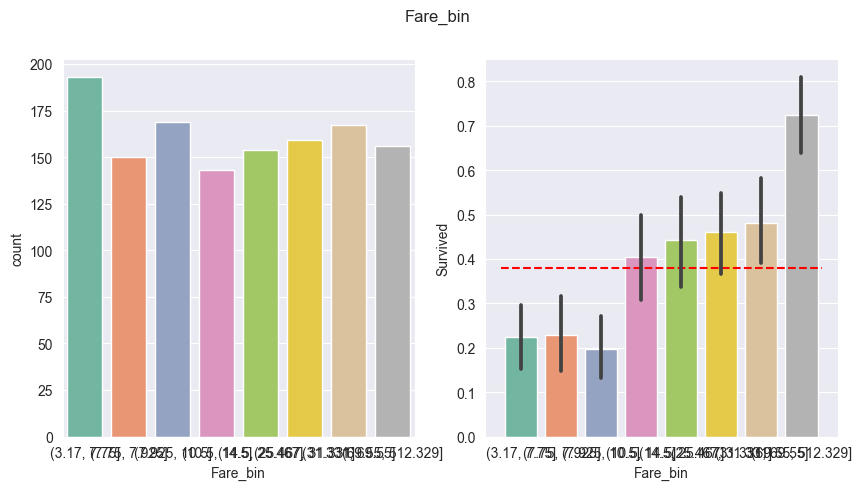

In [16]:
#Fare
df["Fare_bin"] = pd.qcut(df["Fare"], 8)
plot_category(df, "Fare_bin")

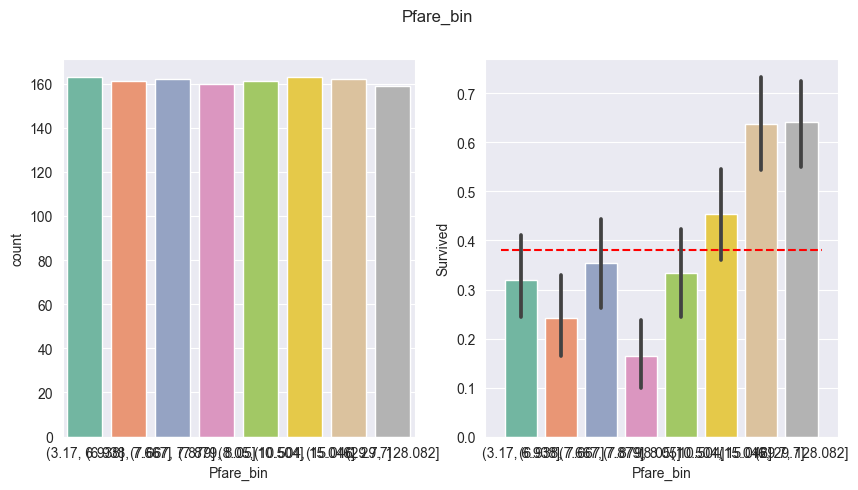

In [17]:
#Pfare
df["Pfare_bin"] = pd.qcut(df["Pfare"], 8)
plot_category(df, "Pfare_bin")

#单个预测能力排名
基于图形主观的判断
####强预测能力
·Title，Sex
·Pclass，Pfare
####中预测能力
·Embarked
####弱预测能力
·Family，Parch，Sibsip
####无预测能力特征
·Age

###重点关注Title这个指标

###删除以后用不到的特征, 主要目的是简化数据显示, 重点关注重要的特征.

In [18]:
#df.drop(["Sex", "Cabin", "Family", "Parch", "SibSp", "Age", "Age_bin", "Fare_bin","Title2"], axis=1, inplace=True)
df.drop(['Title2'],axis =1 ,inplace =True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,"(18.0, 23.0]",1,7.25000,"(3.17, 7.75]","(6.938, 7.667]"
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,"(34.0, 45.0]",1,35.64165,"(69.55, 512.329]","(29.7, 128.082]"
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,"(23.0, 28.0]",0,7.92500,"(7.75, 7.925]","(7.879, 8.05]"
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,"(34.0, 45.0]",1,26.55000,"(31.331, 69.55]","(15.046, 29.7]"
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,"(34.0, 45.0]",0,8.05000,"(7.925, 10.5]","(7.879, 8.05]"


###1.1.2特征交叉

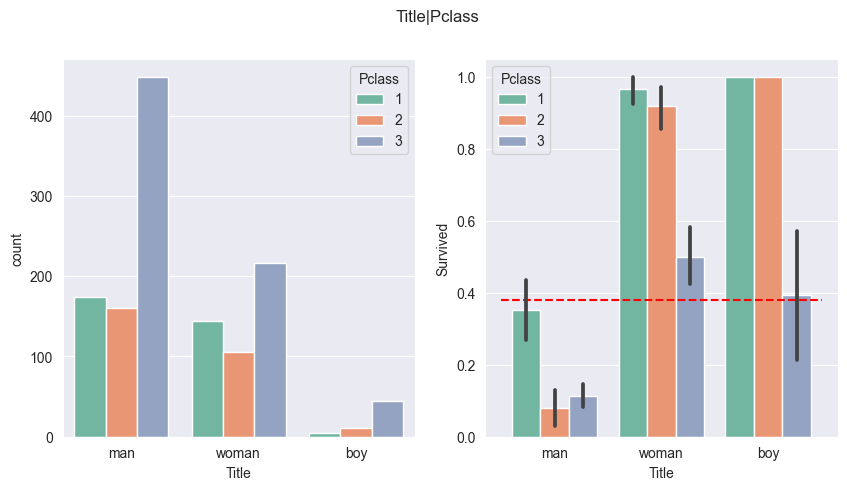

In [19]:
#Title与Pclass交叉
plot_category(df, "Title", group="Pclass")

man不管是什么Pclass, 都无法达到平均生存率, Pclass == 1的man稍低于平均生存率
woman不管是什么Pclass, 都超过了平均生存率, Pclass == 3的woman稍高于平均生存率
boy不管是什么Pclass, 都超过了平均生存率, Pclass == 3的boy接近于平均生存率

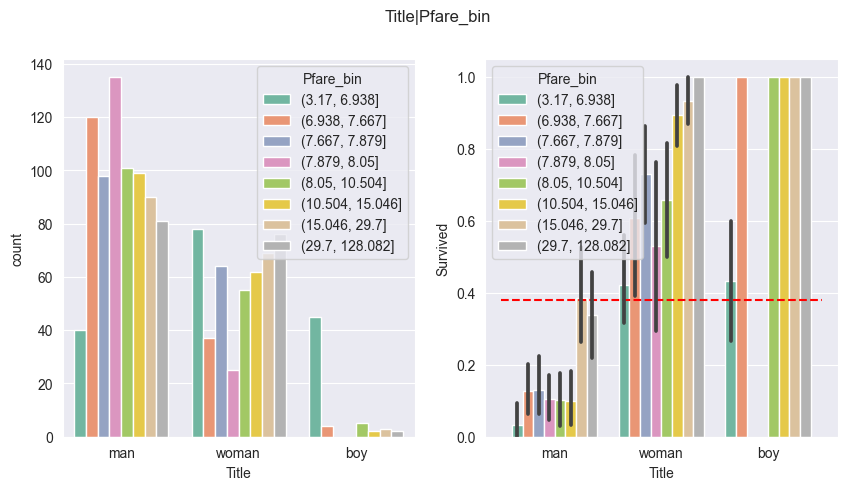

In [20]:
#Title与Pfare交叉
plot_category(df, "Title", group="Pfare_bin")

对于man, 第2高档的Pfare的生存率接近于平均值.
对于woman或boy, 最低档的Pfare的生存率在平均值附近.

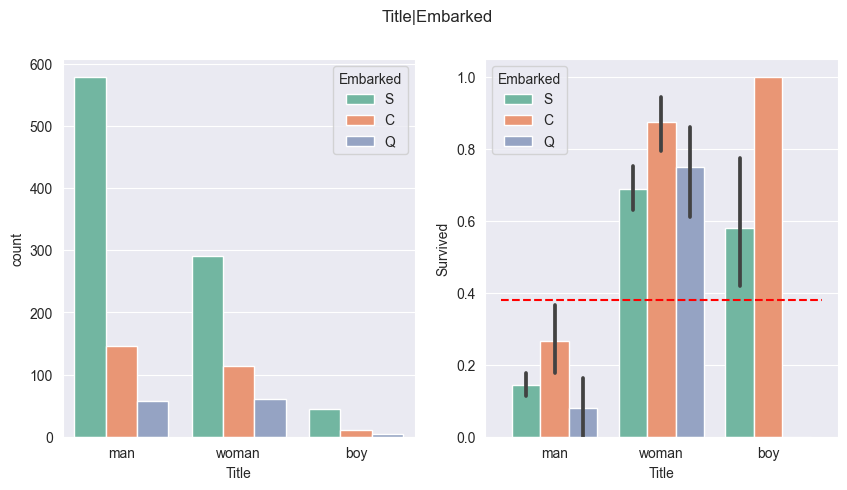

In [21]:
#Title与Embarked交叉
plot_category(df, "Title", group="Embarked")

Embarked == Q的boy, 生存率为0%, 可能是有偶然性的, 因为这样的样本太少.
其他的group形状符合预期.

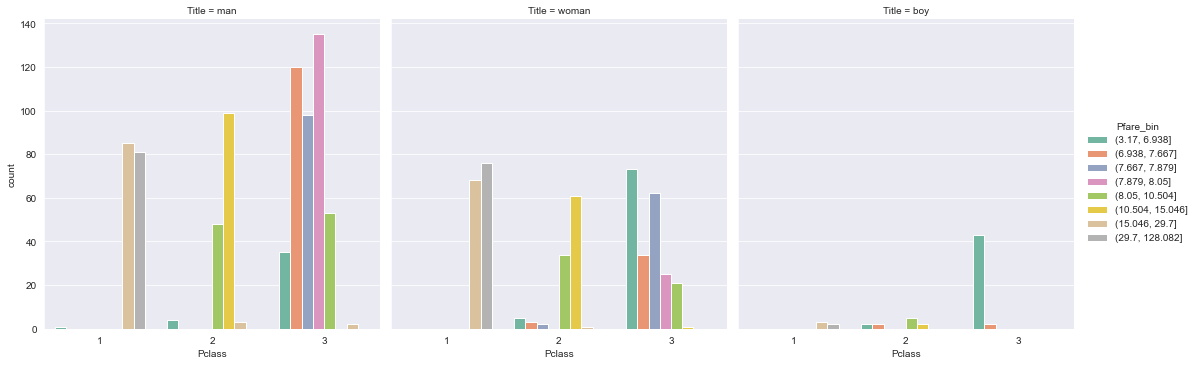

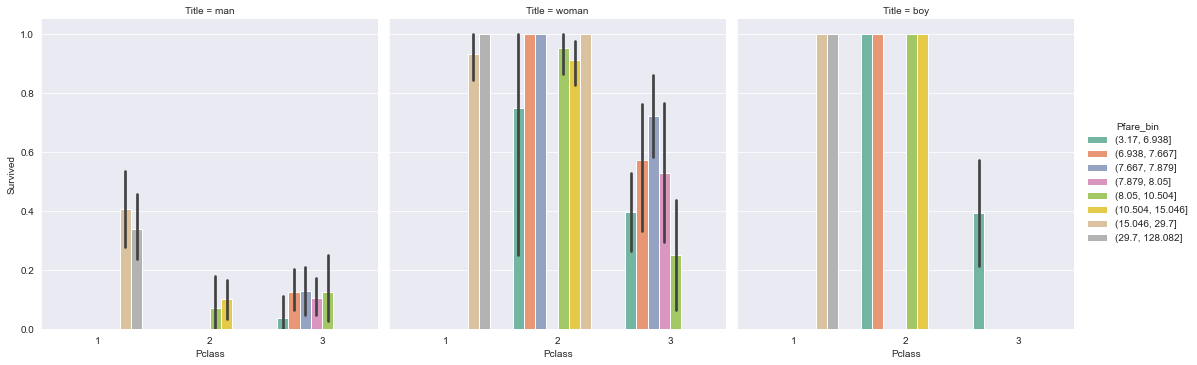

In [22]:
#Title, Pclass, Pfare交叉
sns.catplot(x = 'Pclass' , col = 'Title',hue = 'Pfare_bin' ,data = df ,kind = 'count')
sns.catplot(x = 'Pclass' ,y = 'Survived', col = 'Title',hue = 'Pfare_bin' ,data = df ,kind = 'bar')

·对于man, 在Embarked == S, 第2高Pfare档位, 生存率接近于平均值
·对于woman, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值
·对于boy, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值

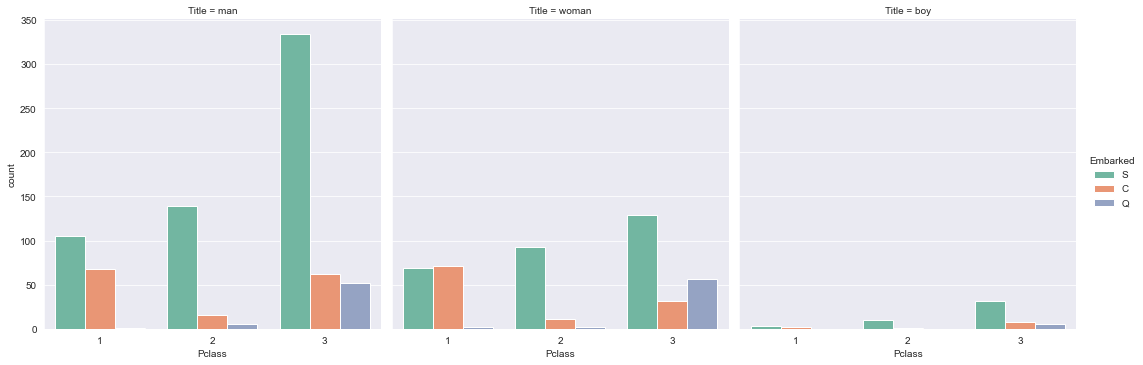

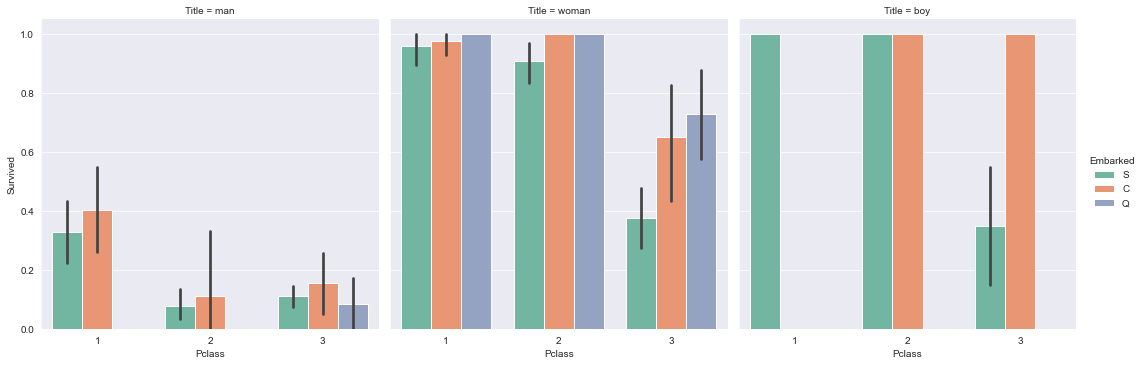

In [23]:
#Title, Pclass, Embarked交叉
sns.catplot(x = 'Pclass' , col = 'Title',hue = 'Embarked' ,data = df ,kind = 'count')
sns.catplot(x = 'Pclass' ,y = 'Survived', col = 'Title',hue = 'Embarked' ,data = df ,kind = 'bar')

·对于man, 在Embarked == S, 第2高Pfare档位, 生存率接近于平均值
·对于woman, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值
·对于boy, 在Embarked == S, 最低Pfare档位, 生存率接近于平均值

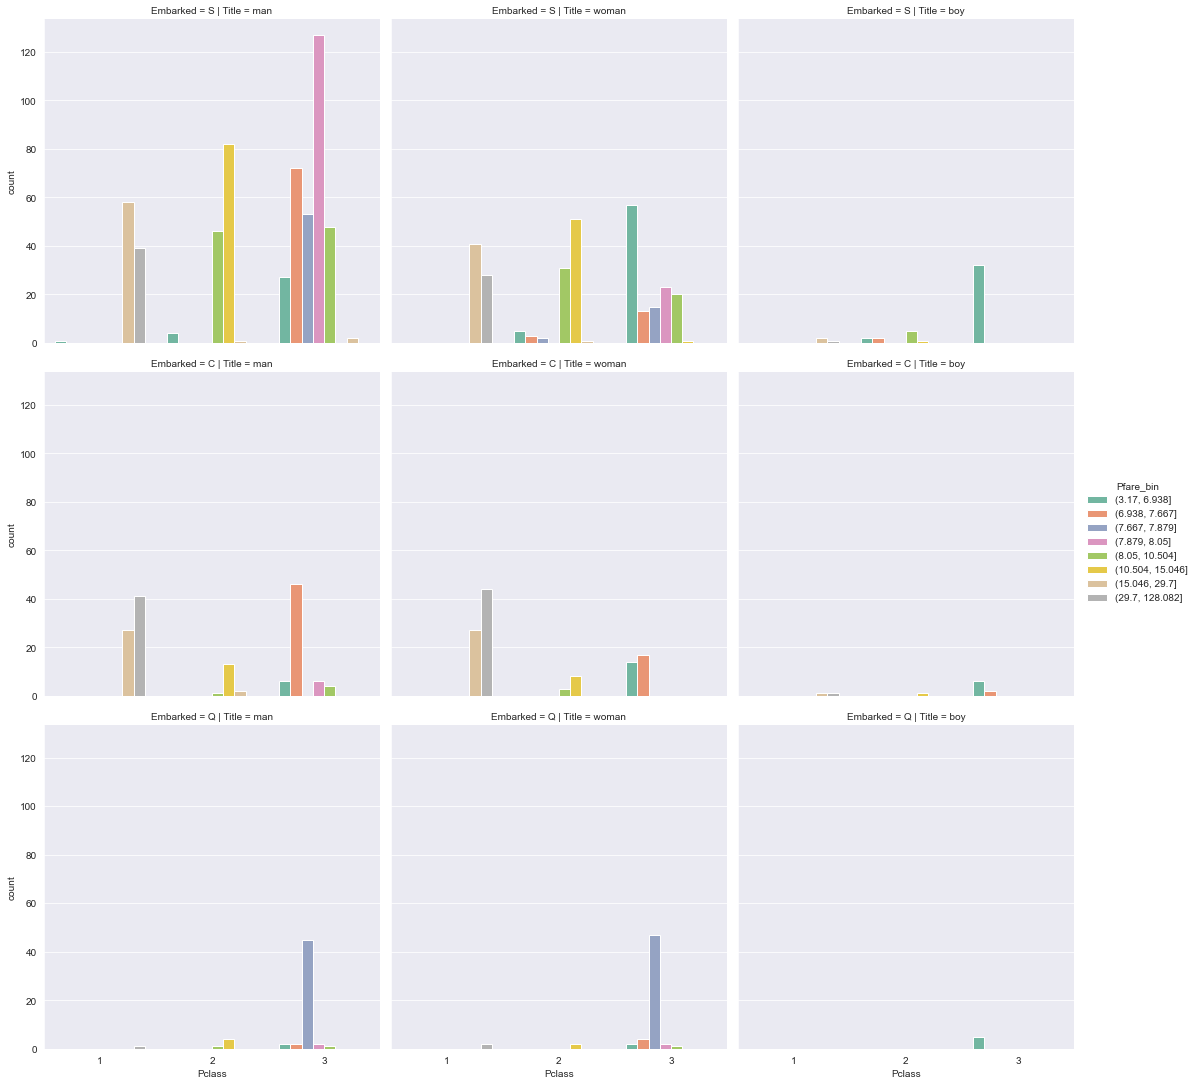

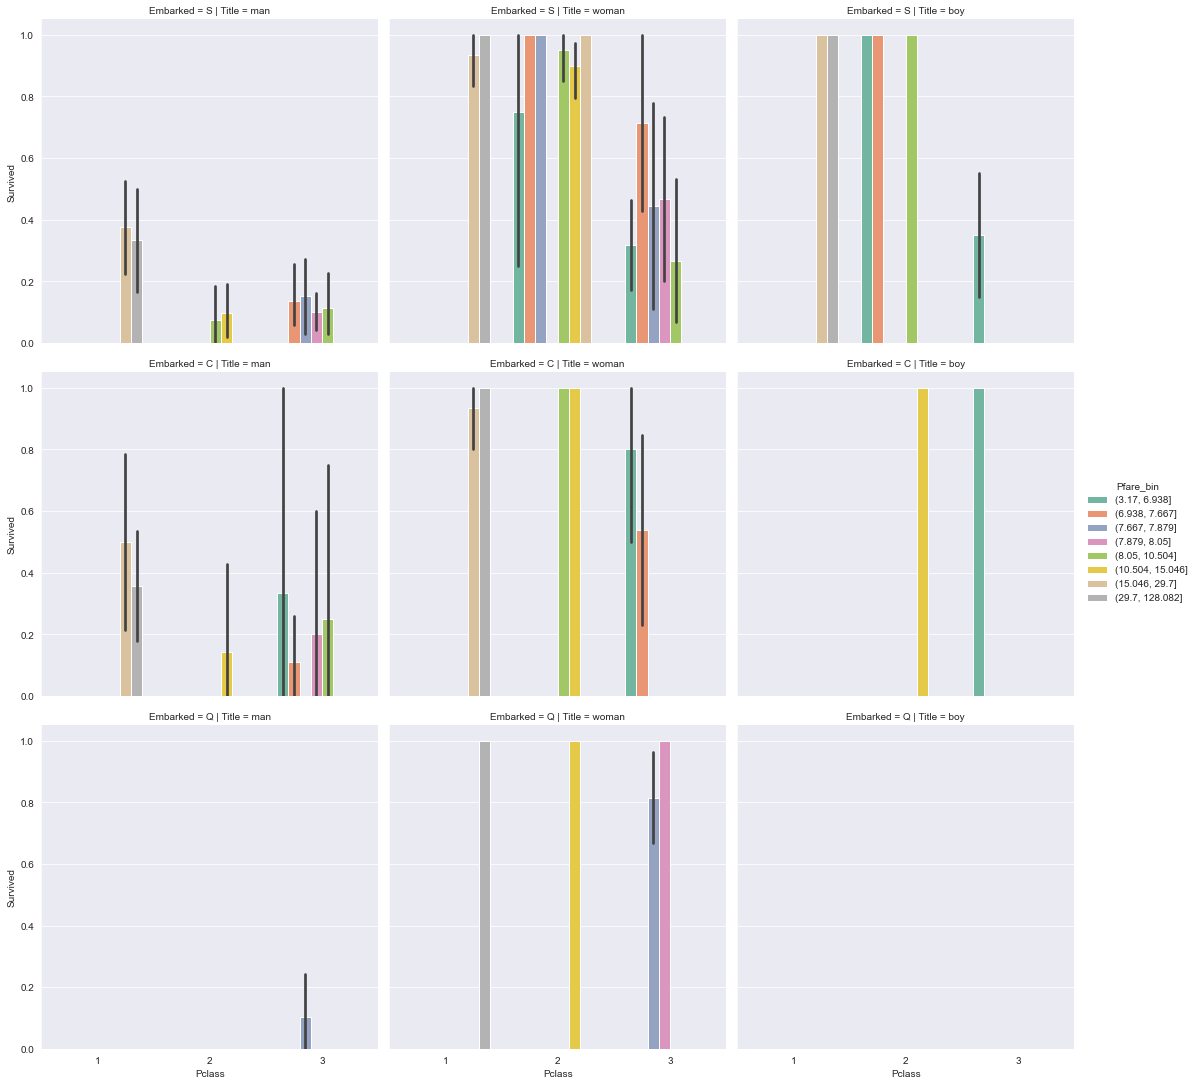

In [24]:
#Title, Pclass, Pfare_bin, Embarked交叉
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df, kind="bar")

·对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
·对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
·对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值

###小结
对于单个特征进行了排名, 对特征的预测能力有个总体的判断
使用二重交叉特征, 三重交叉特征, 四重交叉特征, 对于发现那些异常情况非常有帮助.
发现二重交叉特征, 三重交叉特征的异常情况是和四重交叉特征的异常情况不矛盾的, 是一致的.
因此, 只保留下四重交叉特征的异常情况:
对于man, Pclass == 1, Embarked == "S", Pfare第2高档位上, 生存率高于平均值
对于woman, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
对于boy, Pclass == 3, Embarked == "S", Pfare最低档位上, 生存率接近于平均值
还有一些小样本的情况.

In [25]:
df.loc[(df.Title == 'man')&(df.Pclass == 1 )&(df.Embarked.isin(["S"]))   #isin 用于清洗数据筛选过滤掉一些行
       &(26.832 < df.Pfare)&(df.Pfare <= 31.679),
       "Survived"].mean()

0.5833333333333334

In [26]:
df.loc[(df.Title == "woman") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"]))
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3142857142857143

In [27]:
df.loc[(df.Title == "boy") 
       & (df.Pclass == 3)
       & (df.Embarked.isin(["S"])) 
       & (df.Pfare <= 6.323),
       "Survived"].mean()

0.3157894736842105

验证了上面说的三种异常情况.
对于man的异常情况, 生存率是58%, 虽然高于平均生存率(38%), 但是只比50%高一点点.
对于woman或者boy的异常情况, 生存率分为了31.4%, 31.6%, 如果预测他们为死亡, 看起来不错.
但是, 并不打算选择直接使用交叉特征做预测, 原因:
3种异常情况的样本并不太多, 而且准确率也不算高, 因此, 总体准确率不会提高太多.
有过拟的风险, 准确率要进一步下调.
想法比较naive, 没有用到任何机器学习模型.
并不好评估泛化能力.
虽然不能做出预测, 但是, 对各个特征以及它们之间的交叉情况有了非常直观的了解, 为以后的建模, 打下了基础, 比如:
Title是目前发现的最重要特征, 下文中, 对样本的分治以Title为主.
Pclass是目前发现第二重要的特征.
Pfare是目前发现第三重要的特征.
Embarked是目前发现第四重要的特征, 发现的三种异常情况都是在"S"上. 当然, 还有一些小样本情况.

#使用WCG模型对WCG乘客进行预测
##WCG模型的核心概念: Woman-Child-Groups (WCG)
注意, WCG不同于WCG模型, WCG是一种分组方法, WCG模型是基于WCG的预测模型.
WCG用一句话来概括, 就是: 将一个家庭内的所有女性(包括女保姆)或孩子认定为一组.
需要特别留意的是: 一个家庭内的成年男性并没有分到组里面.
这背后的逻辑是:
·结合当时的疏散原则即可发现
一个家庭内的成员活动在一起, 同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死.
男人因为"女士和孩子优先"这条规则, 并不遵循第1条逻辑.
虽然传统意义上, 女保姆不算是家庭成员, 但是女保姆和东家活动在一起, 也符合"女士和孩子优先"这条规则的, 因此, 女保姆的生存率和东家的女生孩子的生存率应该是没有任何区别的.

##WCG组号(GroupId)的计算方法: GroupId = Surname + Pclass + Ticket(舍掉最后一位) + Fare + Embarked
一家人就应该有相同的Surname, 和中国不同, 很多国家女性嫁人以后, 就随丈夫的姓氏.
一家人应该是相同的阶层.
一家人应该是使用相同的船票.
其中Ticket舍掉最后一位, 因为发现有些实际上是一家人, 但是Ticket最后一位不同(这种情况并不多见, 发现这种现象的人观察力惊人!)
因为舍掉了最后一位, 有可能两张不同Ticket被认为是相同的Ticket了, 因此, 需要Fare, Embarked来进一步确认.

###关于GroupId的后续处理(修正方法):
将所有的man的GroupId赋值为"noGroup", 因为前面提到了, man并不属于任何WCG.
将组内成员个数为1的乘客的GroupId, 赋值为"noGroup", 逻辑很简单, 单独一个人, 不能算是一个"Group", 另外, 对于预测毫无用处, 单独一个人无法用来预测其他乘客的生死.
将女保姆的GroupId改为东家的GroupId, 关于女保姆的认定方法会在下文中细讲.

In [28]:
df['Surname'] = df['Name'].str.split(",").str[0]       #使用的是str[0]  不是单独的[0]

df['Ticket_id']= (
df.Pclass.astype(str)
+ '-'
+ df.Ticket.str[:-1].astype(str)                      #使用astype 进行格式的更改
+ '-'
+ df.Fare.astype(str)
+ '-'
+df.Embarked.astype(str)
)

df["Group_id"] = df['Surname'] + '-' + df["Ticket_id"]

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,"(18.0, 23.0]",1,7.25000,"(3.17, 7.75]","(6.938, 7.667]",Braund,3-A/5 2117-7.25-S,Braund-3-A/5 2117-7.25-S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,"(34.0, 45.0]",1,35.64165,"(69.55, 512.329]","(29.7, 128.082]",Cumings,1-PC 1759-71.2833-C,Cumings-1-PC 1759-71.2833-C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,"(23.0, 28.0]",0,7.92500,"(7.75, 7.925]","(7.879, 8.05]",Heikkinen,3-STON/O2. 310128-7.925-S,Heikkinen-3-STON/O2. 310128-7.925-S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,"(34.0, 45.0]",1,26.55000,"(31.331, 69.55]","(15.046, 29.7]",Futrelle,1-11380-53.1-S,Futrelle-1-11380-53.1-S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,"(34.0, 45.0]",0,8.05000,"(7.925, 10.5]","(7.879, 8.05]",Allen,3-37345-8.05-S,Allen-3-37345-8.05-S


In [29]:
#后续处理
df.loc[df.Title == 'man','Group_id'] =  'noGroup'
df["WC_count"] = (
    df.loc[df.Title != "man"]
    .groupby("Group_id")["Group_id"]               
    .transform("count")                           # transfrom("count") 计数？ 
)
df.loc[df.WC_count <= 1,"Group_id"] = "noGroup"

df.head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,"(18.0, 23.0]",1,7.250000,"(3.17, 7.75]","(6.938, 7.667]",Braund,3-A/5 2117-7.25-S,noGroup,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,"(34.0, 45.0]",1,35.641650,"(69.55, 512.329]","(29.7, 128.082]",Cumings,1-PC 1759-71.2833-C,noGroup,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,"(23.0, 28.0]",0,7.925000,"(7.75, 7.925]","(7.879, 8.05]",Heikkinen,3-STON/O2. 310128-7.925-S,noGroup,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,"(34.0, 45.0]",1,26.550000,"(31.331, 69.55]","(15.046, 29.7]",Futrelle,1-11380-53.1-S,noGroup,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,"(34.0, 45.0]",0,8.050000,"(7.925, 10.5]","(7.879, 8.05]",Allen,3-37345-8.05-S,noGroup,NaN
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,man,NaN,0,8.458300,"(7.925, 10.5]","(8.05, 10.504]",Moran,3-33087-8.4583-Q,noGroup,NaN
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,man,"(45.0, 80.0]",0,25.931250,"(31.331, 69.55]","(15.046, 29.7]",McCarthy,1-1746-51.8625-S,noGroup,NaN
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,boy,"(0.169, 18.0]",4,4.215000,"(14.5, 25.467]","(3.17, 6.938]",Palsson,3-34990-21.075-S,Palsson-3-34990-21.075-S,5.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,woman,"(23.0, 28.0]",2,3.711100,"(10.5, 14.5]","(3.17, 6.938]",Johnson,3-34774-11.1333-S,Johnson-3-34774-11.1333-S,3.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,woman,"(0.169, 18.0]",1,15.035400,"(25.467, 31.331]","(10.504, 15.046]",Nasser,2-23773-30.0708-C,noGroup,1.0


##女保姆的认定
注意: 女保姆只是对一类人的称呼, 并不能保证一定是这样的职业, 是不是这样的职业, 不影响预测.
红框圈出来的两个人, 发现除了Surname不符合GroupId的标准, 其他都符合.

定义一个新的组号(不是WCG的组号, 仅仅用来辅助认定女保姆的): TicketId = Pclass + Ticket(舍掉最后一位) + Fare + Embarked

女保姆的认定标准:

不能是man, 因为WCG以及排除掉man了, 理论上有可能是boy, 实际发现找出来的都是woman, 这是将这类人命名为"女保姆"的原因之一.
GroupId为"noGroup", 即, 假设女保姆是单独一人(女保姆在船上没有家人)和东家在一起.
存在与该样本TicketId相同的WCG(东家的GroupId不能为"noGroup")
认定为女保姆以后, 将该样本的GroupId(原先为"noGroup")修正为东家的GroupId, 即女保姆算是东家的成员.

思考：
前面对GroupId的后续处理中, 将组内成员个数为1的乘客的GroupId, 赋值为"noGroup"(下文中简称为"规则2"),
基于女保姆的认定标准3, 意味着如果东家是一个人的话, 女保姆不会被认定为女保姆.
那么, 规则2是不是有合理性呢?
答案是有合理性.
因为规则2虽然会造成"如果东家是一个人的话, 女保姆不会被认定为女保姆",
但是更多的避免了"两个乘客恰好只是同票, 实际上没有任何关系, 既不是同一个家庭, 也不是东家与女保姆的关系".
规则2要求家庭成员至少是2个, 那么那个"异姓"的是女保姆的概率就非常大了, 如果家庭成员只有1个, 那个"异姓"的是女保姆的概率比较小.

In [30]:
indices = []
count = 0
for i in range(n_all):
    if df.loc[i, "Title"] != "man" and df.loc[i, "Group_id"] == "noGroup":
        idx = np.flatnonzero(
            (df["Ticket_id"] == df.loc[i, "Ticket_id"])
            & (df["Group_id"] != "noGroup")
        )
        if len(idx):
            df.loc[i, "Group_id"] = df.loc[idx[0], "Group_id"]
            indices.append(i)
            count += 1
print(f"发现了{count}个女保姆")
df.loc[indices]

发现了11个女保姆


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count
337,338,1.0,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.5000,E40,C,woman,"(34.0, 45.0]",0,26.900000,"(69.55, 512.329]","(15.046, 29.7]",Burns,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
708,709,1.0,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S,woman,"(18.0, 23.0]",0,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
950,951,NaN,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,PC 17608,262.3750,B61,C,woman,"(34.0, 45.0]",0,37.482143,"(69.55, 512.329]","(29.7, 128.082]",Chaudanson,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0
1032,1033,NaN,1,"Daniels, Miss. Sarah",female,33.0,0,0,113781,151.5500,NaN,S,woman,"(28.0, 34.0]",0,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0
1067,1068,NaN,2,"Sincock, Miss. Maude",female,20.0,0,0,C.A. 33112,36.7500,NaN,S,woman,"(18.0, 23.0]",0,9.187500,"(31.331, 69.55]","(8.05, 10.504]",Sincock,2-C.A. 3311-36.75-S,Davies-2-C.A. 3311-36.75-S,1.0
1140,1141,NaN,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C,woman,NaN,1,7.227100,"(10.5, 14.5]","(6.938, 7.667]",Khalil,3-266-14.4542-C,Zabour-3-266-14.4542-C,1.0
1171,1172,NaN,3,"Oreskovic, Miss. Jelka",female,23.0,0,0,315085,8.6625,NaN,S,woman,"(18.0, 23.0]",0,8.662500,"(7.925, 10.5]","(8.05, 10.504]",Oreskovic,3-31508-8.6625-S,Cacic-3-31508-8.6625-S,1.0
1258,1259,NaN,3,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",female,22.0,0,0,3101295,39.6875,NaN,S,woman,"(18.0, 23.0]",0,5.669643,"(31.331, 69.55]","(3.17, 6.938]",Riihivouri,3-310129-39.6875-S,Panula-3-310129-39.6875-S,1.0
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",female,31.0,0,0,16966,134.5000,E39 E41,C,woman,"(28.0, 34.0]",0,26.900000,"(69.55, 512.329]","(15.046, 29.7]",Wilson,1-1696-134.5-C,Spedden-1-1696-134.5-C,1.0
1266,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,PC 17608,262.3750,NaN,C,woman,"(34.0, 45.0]",0,37.482143,"(69.55, 512.329]","(29.7, 128.082]",Bowen,1-PC 1760-262.375-C,Ryerson-1-PC 1760-262.375-C,1.0


发现这11个女保姆里面, 有9个是测试集里面的, 最多可以提高成绩9/418=2.15%, 说明发现女保姆的努力是有价值的.
下文可以发现, 其中3个女保姆被预测死亡, 分别是索引号为1140, 1171, 1258, 她们的Pclass都为3, 其他都被预测为生存, 她们的Pclass都为1或2.

##非WCG乘客("noGroup")与WCG乘客(非"noGroup")的区别
下文中会根据Group_id是否为"noGroup", 对样本进行分治, WCG乘客会用WCG模型进行预测, 非WCG乘客会用其他模型进行预测
在此之前, 有必要说明一下, 这种分治是有必要的.

###Title分布比较

In [31]:
df.head(80)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,man,"(18.0, 23.0]",1,7.250000,"(3.17, 7.75]","(6.938, 7.667]",Braund,3-A/5 2117-7.25-S,noGroup,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,woman,"(34.0, 45.0]",1,35.641650,"(69.55, 512.329]","(29.7, 128.082]",Cumings,1-PC 1759-71.2833-C,noGroup,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,"(23.0, 28.0]",0,7.925000,"(7.75, 7.925]","(7.879, 8.05]",Heikkinen,3-STON/O2. 310128-7.925-S,noGroup,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,woman,"(34.0, 45.0]",1,26.550000,"(31.331, 69.55]","(15.046, 29.7]",Futrelle,1-11380-53.1-S,noGroup,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,man,"(34.0, 45.0]",0,8.050000,"(7.925, 10.5]","(7.879, 8.05]",Allen,3-37345-8.05-S,noGroup,NaN
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,man,NaN,0,8.458300,"(7.925, 10.5]","(8.05, 10.504]",Moran,3-33087-8.4583-Q,noGroup,NaN
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S,man,"(45.0, 80.0]",0,25.931250,"(31.331, 69.55]","(15.046, 29.7]",McCarthy,1-1746-51.8625-S,noGroup,NaN
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,boy,"(0.169, 18.0]",4,4.215000,"(14.5, 25.467]","(3.17, 6.938]",Palsson,3-34990-21.075-S,Palsson-3-34990-21.075-S,5.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S,woman,"(23.0, 28.0]",2,3.711100,"(10.5, 14.5]","(3.17, 6.938]",Johnson,3-34774-11.1333-S,Johnson-3-34774-11.1333-S,3.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,woman,"(0.169, 18.0]",1,15.035400,"(25.467, 31.331]","(10.504, 15.046]",Nasser,2-23773-30.0708-C,noGroup,1.0


In [32]:
print(f"非WCG组号个数: {df.Group_id.loc[ lambda x: x == 'noGroup'].nunique()}")
#print(f"非WCG组号个数：{df['Group_id'].groupby(by=df['Group_id']).nunique()}")
print(f"WCG组号个数: {df.Group_id.loc[ lambda x: x != 'noGroup'].nunique()}")

print('-'*80)
print(f"非WCG乘客个数: {df.Group_id.loc[lambda x: x == 'noGroup'].count()}")
print(f"WCG乘客个数: {df.Group_id.loc[lambda x: x != 'noGroup'].count()}")

print('-'*80)
print("非WCG乘客的Title分布:")
print(df.loc[df.Group_id == "noGroup", "Title"].value_counts())

print('-'*80)
print("全体乘客的Title分布:")
print(df.Title.value_counts())

print('-'*80)
print("非WCG覆盖率:")
print((df.loc[df.Group_id == "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

print('-'*80)
print("WCG覆盖率:")
print((df.loc[df.Group_id != "noGroup", "Title"].value_counts() / df.Title.value_counts()).fillna(0.0))

非WCG组号个数: 1
WCG组号个数: 80
--------------------------------------------------------------------------------
非WCG乘客个数: 1079
WCG乘客个数: 230
--------------------------------------------------------------------------------
非WCG乘客的Title分布:
man      782
woman    295
boy        2
Name: Title, dtype: int64
--------------------------------------------------------------------------------
全体乘客的Title分布:
man      782
woman    466
boy       61
Name: Title, dtype: int64
--------------------------------------------------------------------------------
非WCG覆盖率:
man      1.000000
woman    0.633047
boy      0.032787
Name: Title, dtype: float64
--------------------------------------------------------------------------------
WCG覆盖率:
boy      0.967213
man      0.000000
woman    0.366953
Name: Title, dtype: float64


只有占比230/1309的乘客是WCG乘客, 另外占比1079/1309的乘客需要其他模型来进行预测.
大约有96.7%的boy是WCG成员.
大约有36.7%的woman是WCG成员.
没有man是WCG成员.

####生存率的区别

In [33]:
#对于man
df.loc[(df.Title == 'man')&(df.Group_id == 'noGroup'),"Survived"].mean()

0.1601489757914339

In [34]:
#对于boy
df.loc[(df.Title == "boy") & (df.Group_id != "noGroup"), "Survived"].mean()

0.575

In [35]:
#对于woman 
#非WCG
print('-'*20+f'非WCG woman的生存率' +"-"*20)
print(df.loc[(df.Title == 'woman')&(df.Group_id == 'noGroup'),'Survived'].mean())

--------------------非WCG woman的生存率--------------------
0.8181818181818182


In [36]:
print('-'*20+f'WCG woman的生存率' +"-"*20)
print(df.loc[(df.Title == 'woman')&(df.Group_id != 'noGroup'),'Survived'].mean())

--------------------WCG woman的生存率--------------------
0.6120689655172413


非WCG乘客与WCG乘客的分布是相差比较大的.
非WCG乘客与WCG乘客的各个Title生存率也是相差比较大的.
因此, 这种分治, 是有必要的.
组内生存率

###组内生存率
发现一个家庭内的成员同生或同死的概率极大, 可以利用这个性质, 如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死

In [37]:
df['WCSurvived'] = df.loc[df.Group_id != 'noGroup'].groupby('Group_id').Survived.transform('mean')

In [38]:
print("组内生存率的分布:")
print(df.WCSurvived.value_counts())

组内生存率的分布:
1.00    134
0.00     76
0.75      6
0.50      5
Name: WCSurvived, dtype: int64


发现组内生存率大部分是0.0或者1.0, 即同生同死的概率非常大, 组内生存率的预测能力比以往发现的任何特征都更强!

In [39]:
df.loc[df.WCSurvived == 0.75]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
25,26,1.0,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S,woman,"(34.0, 45.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
182,183,0.0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S,boy,"(0.169, 18.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
233,234,1.0,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S,woman,"(0.169, 18.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
261,262,1.0,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,boy,"(0.169, 18.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1045,1046,NaN,3,"Asplund, Master. Filip Oscar",male,13.0,4,2,347077,31.3875,NaN,S,boy,"(0.169, 18.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75
1270,1271,NaN,3,"Asplund, Master. Carl Edgar",male,5.0,4,2,347077,31.3875,NaN,S,boy,"(0.169, 18.0]",6,4.483929,"(31.331, 69.55]","(3.17, 6.938]",Asplund,3-34707-31.3875-S,Asplund-3-34707-31.3875-S,6.0,0.75


组内生存率为0.75, 但是:
Pclass == 3, Pfare处在最低档, Embarked == "S", 这种情况属于之前发现的boy大概率死亡的情况.

In [40]:
df.loc[df.WCSurvived == 0.5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
297,298,0.0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,woman,"(0.169, 18.0]",3,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
305,306,1.0,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,boy,"(0.169, 18.0]",3,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
498,499,0.0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,woman,"(23.0, 28.0]",3,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Allison,1-11378-151.55-S,Allison-1-11378-151.55-S,3.0,0.5
708,709,1.0,1,"Cleaver, Miss. Alice",female,22.00,0,0,113781,151.55,NaN,S,woman,"(18.0, 23.0]",0,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Cleaver,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5
1032,1033,NaN,1,"Daniels, Miss. Sarah",female,33.00,0,0,113781,151.55,NaN,S,woman,"(28.0, 34.0]",0,25.258333,"(69.55, 512.329]","(15.046, 29.7]",Daniels,1-11378-151.55-S,Allison-1-11378-151.55-S,1.0,0.5


组内生存率为0.5, 但是:
Pclass == 1, Pfare处在较高档, 这种情况属于之前发现的woman大概率生存的情况.
###找出哪些组是全部成员都在测试集里面的:
前面提到了"如果一个组内的成员一部分在训练集里面, 一部分在测试集里面, 根据训练集的生存率就可以去预测测试集成员的生死"
但是, 如果一个组内的全部成员都在测试集里面, 又该如何?

In [41]:
group_test = set(df[n_train:].Group_id.unique()) - set(df[:n_train].Group_id.unique())
df.loc[df.Group_id.isin(group_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45.00,0,1,112378,59.4000,NaN,C,woman,"(34.0, 45.0]",1,29.700000,"(31.331, 69.55]","(15.046, 29.7]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.00,0,1,112378,59.4000,NaN,C,woman,"(18.0, 23.0]",1,29.700000,"(31.331, 69.55]","(15.046, 29.7]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,NaN
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.00,0,2,350405,12.1833,NaN,S,woman,"(34.0, 45.0]",2,6.091650,"(10.5, 14.5]","(3.17, 6.938]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",female,1.00,1,1,350405,12.1833,NaN,S,woman,"(0.169, 18.0]",2,6.091650,"(10.5, 14.5]","(3.17, 6.938]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,NaN
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26.00,0,2,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,"(23.0, 28.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,boy,"(0.169, 18.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.00,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,"(0.169, 18.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,NaN
1083,1084,NaN,3,"van Billiard, Master. Walter John",male,11.50,1,1,A/5. 851,14.5000,NaN,S,boy,"(0.169, 18.0]",2,4.833333,"(10.5, 14.5]","(3.17, 6.938]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN
1235,1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,boy,NaN,2,4.833333,"(10.5, 14.5]","(3.17, 6.938]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,NaN


全部成员都在测试集里的家族有: Gibson, Klasen, Peacock, van Billiard.
Gibson家族的 Pclass == 1, Pfare == 29.7(第9档), Embarked == "C", Title == "woman"
Klasen家族的 Pclass == 3, Pfare == 6.09(第1档), Embarked == "S", Title == "woman"
Peacock家族的 Pclass == 3, Pfare == 4.59(第1档), Embarked == "S", Title == "woman"(2个woman, 1个boy, 算做woman, 因为同生同死, 少数服从多数)
van Billiard家族的Pclass == 3, Pfare == 4.83(第1档), Embarked == "S", Title == "boy"

###利用之前的四重交叉特征对这些家族进行预测:
与之前的四重交叉特征分析不同, 之前使用的是全体乘客数据, 这一次, 使用的是WCG乘客数据.

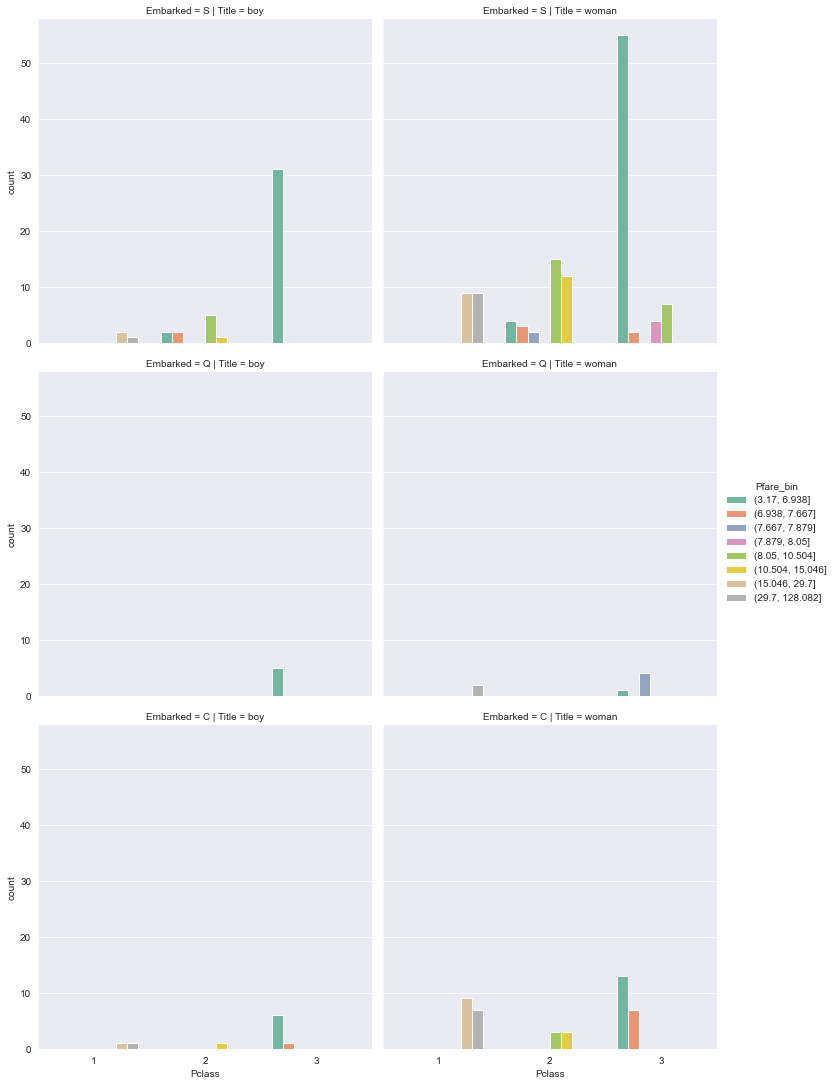

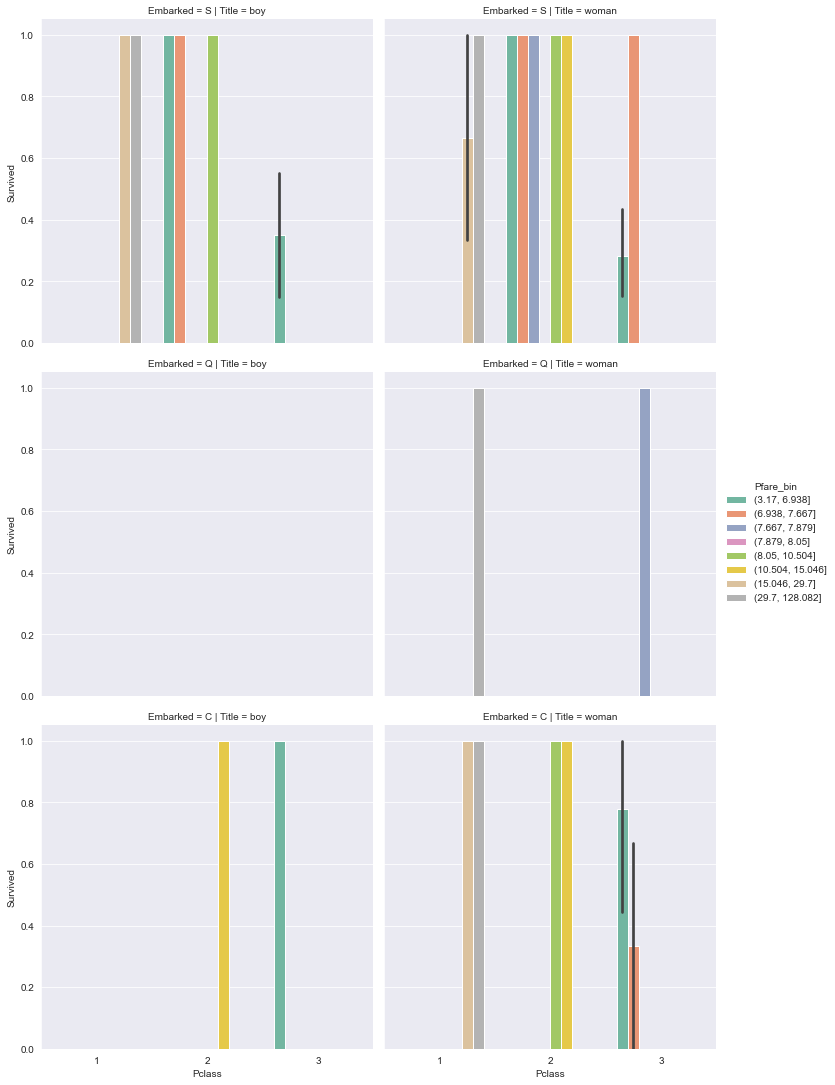

In [42]:
sns.catplot(x="Pclass", y=None, hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="count")
sns.catplot(x="Pclass", y="Survived", hue="Pfare_bin", row="Embarked", col="Title", data=df.loc[df.Group_id != "noGroup"], kind="bar")

根据四重交叉特征, 发现:
Gibson家族大概率应该是同生的.
Klasen, Peacock, van Billiard家族大概率都是同死的.

In [43]:
df.loc[df.Group_id.isin(group_test), "WCSurvived"] = 0.0
df.loc[df.Surname == "Gibson", "WCSurvived"] = 1.0
df.loc[df.Group_id.isin(group_test)].sort_values(by="Surname")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,Family,Pfare,Fare_bin,Pfare_bin,Surname,Ticket_id,Group_id,WC_count,WCSurvived
1259,1260,NaN,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45.00,0,1,112378,59.4000,NaN,C,woman,"(34.0, 45.0]",1,29.700000,"(31.331, 69.55]","(15.046, 29.7]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.00,0,1,112378,59.4000,NaN,C,woman,"(18.0, 23.0]",1,29.700000,"(31.331, 69.55]","(15.046, 29.7]",Gibson,1-11237-59.4-C,Gibson-1-11237-59.4-C,2.0,1.0
1044,1045,NaN,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.00,0,2,350405,12.1833,NaN,S,woman,"(34.0, 45.0]",2,6.091650,"(10.5, 14.5]","(3.17, 6.938]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1154,1155,NaN,3,"Klasen, Miss. Gertrud Emilia",female,1.00,1,1,350405,12.1833,NaN,S,woman,"(0.169, 18.0]",2,6.091650,"(10.5, 14.5]","(3.17, 6.938]",Klasen,3-35040-12.1833-S,Klasen-3-35040-12.1833-S,2.0,0.0
1050,1051,NaN,3,"Peacock, Mrs. Benjamin (Edith Nile)",female,26.00,0,2,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,"(23.0, 28.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1172,1173,NaN,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,boy,"(0.169, 18.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.00,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,woman,"(0.169, 18.0]",2,4.591667,"(10.5, 14.5]","(3.17, 6.938]",Peacock,3-SOTON/O.Q. 310131-13.775-S,Peacock-3-SOTON/O.Q. 310131-13.775-S,3.0,0.0
1083,1084,NaN,3,"van Billiard, Master. Walter John",male,11.50,1,1,A/5. 851,14.5000,NaN,S,boy,"(0.169, 18.0]",2,4.833333,"(10.5, 14.5]","(3.17, 6.938]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0
1235,1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,boy,NaN,2,4.833333,"(10.5, 14.5]","(3.17, 6.938]",van Billiard,3-A/5. 85-14.5-S,van Billiard-3-A/5. 85-14.5-S,2.0,0.0


In [44]:
#检查WCG乘客是否都有了组内生存率
df.loc[(df.Group_id != "noGroup") & df.WCSurvived.isna()].shape[0]

0

##基于组内生存率, 进行预测
·如果woman的组内生存率是0%, 那么预测她死亡, 否则, 预测她生存
·如果乘客是man, 一律预测他死亡.
·如果boy的组内生存率是100%, 那么预测他生存, 否则, 预测他死亡.

背后的逻辑:

·woman的生存率整体上是比较高的, 所以默认预测为生存, 预测她死亡, 需要比较严苛的条件(组内生存率是0%)
·man的生存率整体上是比较低的, 光凭组内生存率, 已经无法预测哪些是幸存者了, 所以, 一律预测为死亡.
·boy的组内生存率如果是100%, 那么预测他生存, 如果是0%, 那么预测他死亡, 这两条没有什么可说的. 除去这两条情况, 测试集总共只剩下4个样本了, 根据分析, 发现这4个样本死亡的概率比较大.

In [50]:
n_train

891

In [51]:
df.loc[n_train : n_all - 1, "Predict"] = 0     #创建一个predict列，并将索引891到1309的行的值为0
df.loc[n_train:n_all-1,"Predict"][(df.Title == 'woman')] = 1
df.loc[n_train:n_all-1,"Predict"][(df.Title == 'woman')&(df["WCSurvived"] == 0)] = 0
df.loc[n_train : n_all - 1, "Predict"][(df.Title == "boy") & (df["WCSurvived"] == 1)] = 1

In [52]:
output = pd.DataFrame(
    {
        "PassengerId": df[n_train:].PassengerId,
        "Survived": df[n_train:].Predict.astype("int"), 
    }
)
output.to_csv("D:\\dataanalyse\\compete\\kaggle\\Titanic\\titanic\\WCG_gender.csv", index=False)        

#对非WCG乘客进行预测
任务分析
之前分析过: 非WCG乘客个数为1079, 其中: man 782个, woman 295个, boy 2个.
非WCG的man生存率为16%.
非WCG的woman生存率为81.8%, 死亡率为18.2%.(因为是在"gender model"基础上进行修正, 因此, 对找到死亡的woman更感兴趣)
非WCG的boy只有2个, 恰好都在测试集里面, 根据分析, 生存率大概率为0%, "gender model"本来就是预测boy为死亡, 并且样本只有2个, 因此, 对于boy, 不需要再建模了.

现在任务很清晰了, 两个任务:

在782个man中寻找出幸存者, 训练集里面生存率只有16%.
在295个woman中寻找出遇难者, 训练集里面死亡率只有18.2%

因为占比很小, 这两项任务都是比较难的, 要有心理准备, 其中一个证据:
这个比赛提交的大部分solutions里面, man全部被预测为死亡, 没有一个幸存者.

In [55]:
#将未分组的乘客找出来重新建一个表
df_noGroup=df[["PassengerId", "Survived", "Title", "Pclass", "Pfare", "Embarked", "Group_id"]]  #?
df_noGroup = df_noGroup.loc[df_noGroup.Group_id == 'noGroup']
del df_noGroup['Group_id']
print(df_noGroup.shape)

(1079, 6)


In [57]:
#将nan和woman区分开来
df_man =df_noGroup.loc[df_noGroup.Title == 'man'].copy()
print(df_man.shape)
df_man.head()

(782, 6)


,PassengerId,Survived,Title,Pclass,Pfare,Embarked
0,1,0.0,man,3,7.25000,S
4,5,0.0,man,3,8.05000,S
5,6,0.0,man,3,8.45830,Q
6,7,0.0,man,1,25.93125,S
12,13,0.0,man,3,8.05000,S


In [60]:
df_woman =df_noGroup.loc[df_noGroup.Title == 'woman'].copy()
print(df_man.shape)
df_woman.head()

(782, 6)


,PassengerId,Survived,Title,Pclass,Pfare,Embarked
1,2,1.0,woman,1,35.64165,C
2,3,1.0,woman,3,7.92500,S
3,4,1.0,woman,1,26.55000,S
9,10,1.0,woman,2,15.03540,C
11,12,1.0,woman,1,26.55000,S


##EDA分析同上

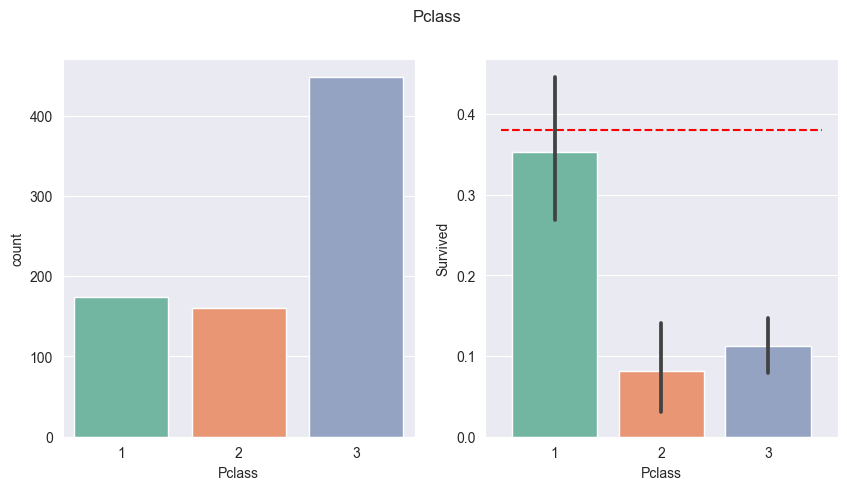

In [61]:
plot_category(df_man, "Pclass")

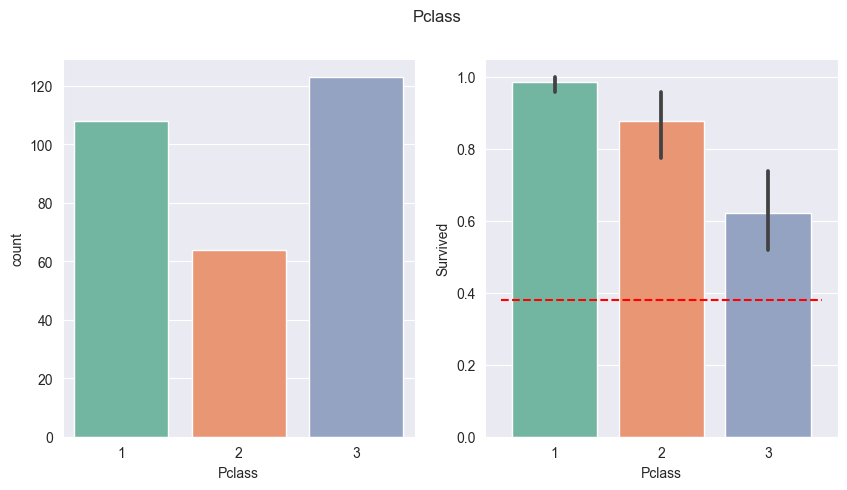

In [62]:
plot_category(df_woman, "Pclass")

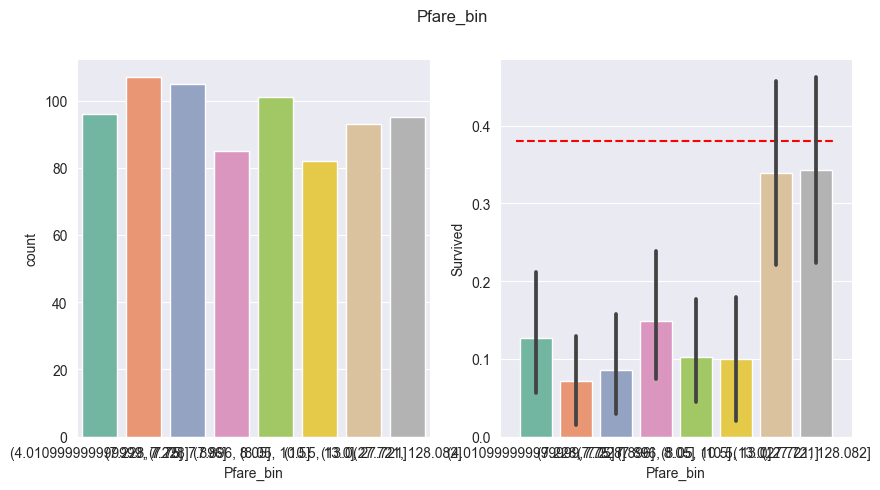

In [64]:
df_man["Pfare_bin"] = pd.qcut(df_man["Pfare"], 8)
plot_category(df_man, "Pfare_bin")

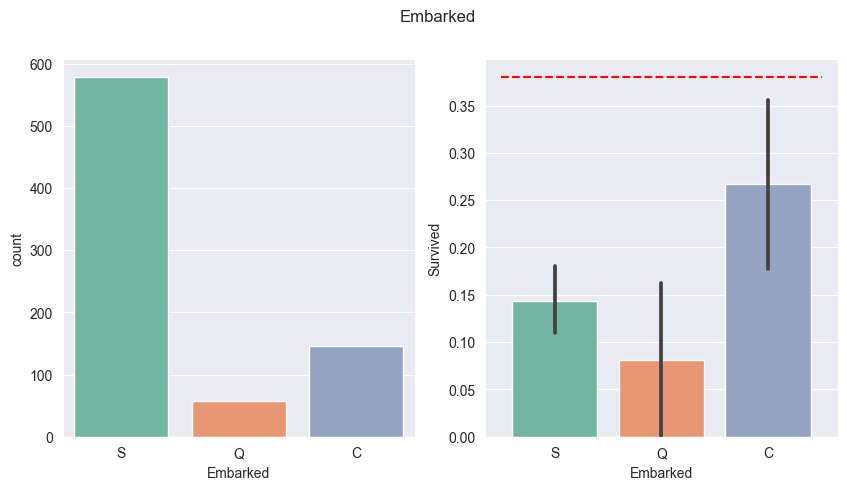

In [65]:
plot_category(df_man, "Embarked")

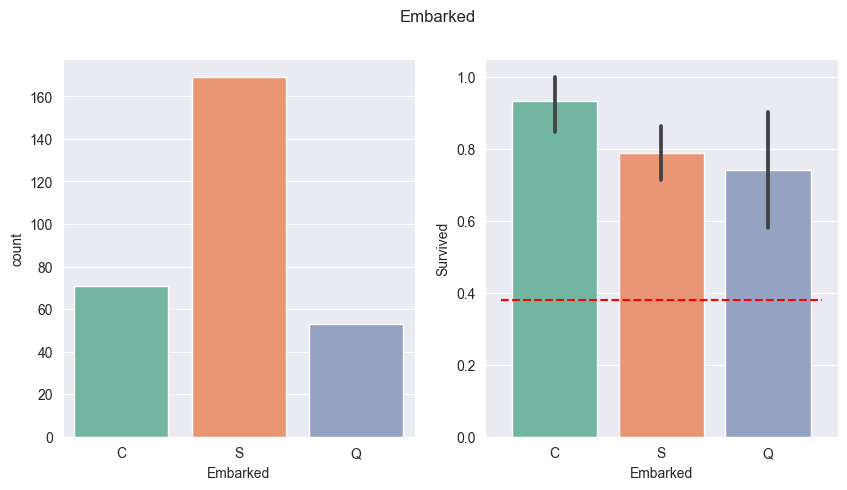

In [66]:
plot_category(df_woman, "Embarked")

##机器学习
###填充缺失值, 独热编码, 划分数据集

<AxesSubplot:>

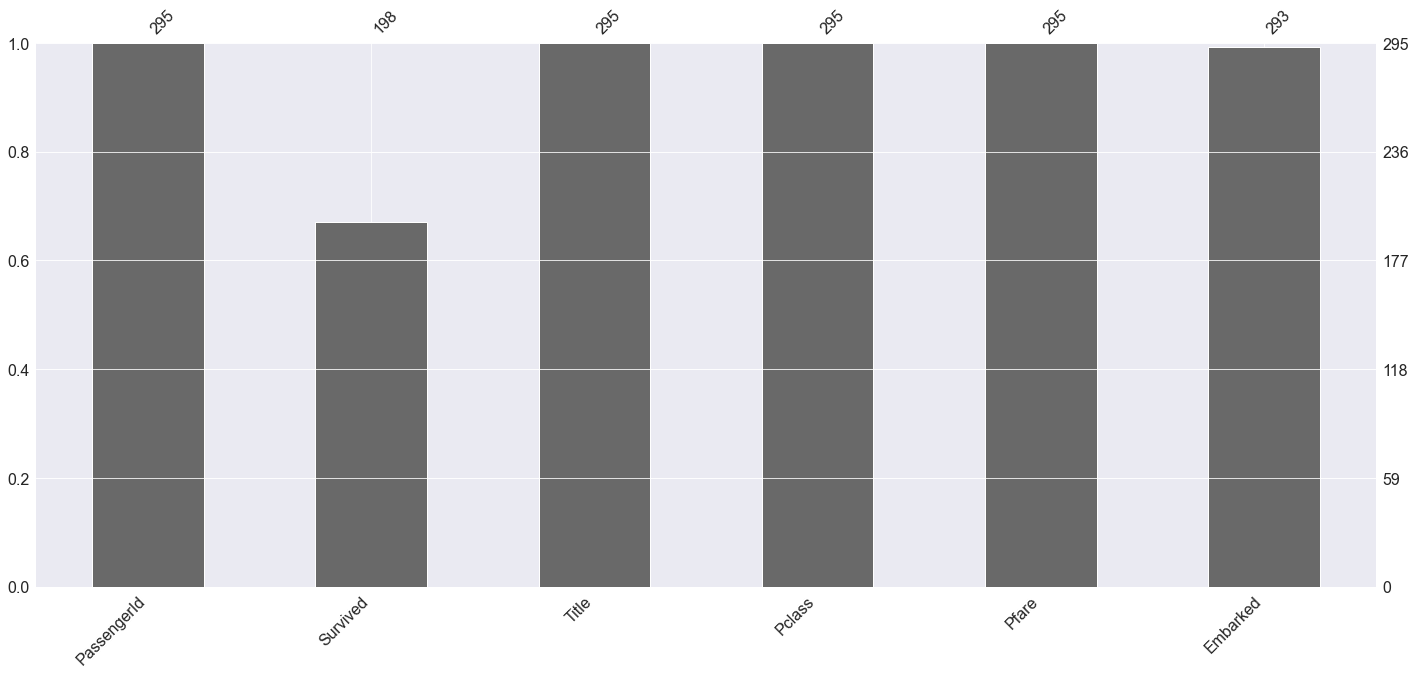

In [76]:
#查看并填充缺失值
import missingno as msno
#msno.matrix(df_man, labels=True)                #相比使用bar，使用matrix比较好，能看出缺失值的位置
msno.bar(df_woman, labels=True)

In [72]:
df_man.Pfare.fillna(df_man.Pfare.mean(), inplace=True)
df_woman.Pfare.fillna(df_woman.Pfare.mean(), inplace=True)

In [77]:
df_man.Embarked.fillna("S", inplace=True)
df_woman.Embarked.fillna("S", inplace=True)

df_man.Pfare = (df_man.Pfare - df_man.Pfare.mean()) / df_man.Pfare.std()
df_woman.Pfare = (df_woman.Pfare - df_woman.Pfare.mean()) / df_woman.Pfare.std()

In [82]:
#独热编码
X_man = df_man[["Pclass", "Pfare", "Embarked"]]             #man的特征为独热编码做准备
y_man = df_man.Survived            #man的y值
n_man = len(y_man)                 #man的数量个数
n_train_man = y_man.count()        #用于训练的个数
print(y_man,n_man,n_train_man)

0       0.0
4       0.0
5       0.0
6       0.0
12      0.0
13      0.0
17      1.0
20      0.0
21      1.0
23      1.0
26      0.0
27      0.0
29      0.0
30      0.0
33      0.0
34      0.0
35      0.0
36      1.0
37      0.0
42      0.0
45      0.0
46      0.0
48      0.0
51      0.0
54      0.0
55      1.0
57      0.0
60      0.0
62      0.0
64      0.0
67      0.0
69      0.0
70      0.0
72      0.0
73      0.0
74      1.0
75      0.0
76      0.0
77      0.0
80      0.0
81      1.0
83      0.0
86      0.0
87      0.0
89      0.0
90      0.0
91      0.0
92      0.0
93      0.0
94      0.0
95      0.0
96      0.0
97      1.0
99      0.0
101     0.0
102     0.0
103     0.0
104     0.0
105     0.0
107     1.0
108     0.0
110     0.0
112     0.0
115     0.0
116     0.0
117     0.0
118     0.0
120     0.0
121     0.0
122     0.0
124     0.0
126     0.0
127     1.0
129     0.0
130     0.0
131     0.0
134     0.0
135     0.0
137     0.0
138     0.0
139     0.0
143     0.0
144     0.0
145 

In [83]:
y_woman = df_woman.Survived            #df_woman.Survived 写法等同于  df_woman['Survived']
n_woman = len(y_woman)
n_train_woman = y_woman.count()
X_woman = df_woman[["Pclass", "Pfare", "Embarked"]]

In [85]:
#利用get_dummies 实现 one hot encode
X_man = pd.get_dummies(X_man,columns=['Pclass','Embarked'])
X_woman = pd.get_dummies(X_woman,columns=['Pclass','Embarked'])

In [86]:
#将测试集和训练集 的 独热编码分开
X_train_man , X_test_man = X_man[:n_train_man].copy(),X_man[n_train_man:].copy()
y_train_man = y_man[:n_train_man].copy()

X_train_woman, X_test_woman = X_woman[:n_train_woman].copy(), X_woman[n_train_woman:].copy()
y_train_woman = y_woman[:n_train_woman].copy()

X_man.head(), X_woman.head()

(       Pfare  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  Embarked_S
 0  -0.575164         0         0         1           0           0           1
 4  -0.509768         0         0         1           0           0           1
 5  -0.476391         0         0         1           0           1           0
 6   0.951933         1         0         0           0           0           1
 12 -0.509768         0         0         1           0           0           1,
        Pfare  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  Embarked_S
 1   0.941225         1         0         0           1           0           0
 2  -0.680493         0         0         1           0           0           1
 3   0.409267         1         0         0           0           0           1
 9  -0.264459         0         1         0           1           0           0
 11  0.409267         1         0         0           0           0           1)

In [ ]:
##定义相关函数
